In [174]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt


def polaritons(wz, wc, lam):
    def para(wz, wc, lam):
        innerroot = np.sqrt(wz**4 + wc**4 - 2 * wz**2 * wc**2 + 16 * lam**2 * wz * wc)
        return np.sqrt(0.5 * (wz**2 + wc**2 - innerroot)), np.sqrt(
            0.5 * (wz**2 + wc**2 + innerroot)
        )

    def ferro(wz, wc, lam):
        mu = wz * wc / (4 * lam**2)
        g = lam * mu * np.sqrt(2 / (1 + mu))
        wztilde = wz * (1 + mu) / (2 * mu)
        eps = wz * (1 - mu) * (3 + mu) / (8 * mu * (1 + mu))

        innerroot = np.sqrt(
            wztilde**4
            + wc**4
            - 2 * wztilde**2 * wc**2
            + 16 * g**2 * wztilde * wc
            + 4 * (eps**2 * wztilde**2 + eps * wztilde**3 - wc**2 * eps * wztilde)
        )
        return np.sqrt(
            0.5 * (wztilde**2 + wc**2 + 2 * eps * wztilde - innerroot)
        ), np.sqrt(0.5 * (wztilde**2 + wc**2 + 2 * eps * wztilde + innerroot))

    if 4 * lam**2 < wz * wc:
        # paramagnetic phase
        return para(wz, wc, lam)
    else:
        # ferromagnetic phase
        return ferro(wz, wc, lam)


def polaritons_local(wz, wc, lam):
    if 4 * lam**2 < wz * wc:
        root = np.sqrt(0.25 * (wz - wc) ** 2 + lam**2)
        return 0.5 * (wz + wc) - root, 0.5 * (wz + wc) + root
    else:
        raise ValueError("This function only works in the paramagnetic phase.")


def superradiant(wz, wc, T, lam):
    try:
        if 4 * lam**2 >= wz * wc / np.tanh(h * wz / (2 * kb * T)):
            return True
        else:
            return False
    except ZeroDivisionError:
        return False


def f_ACsus(wz, w, lam, mz, mx):
    return wz * mz / ((w + 1j * gamma) ** 2 - wz**2 - (4 * lam**2 / wc) ** 2 * mx**2)


def f_mx(wz, wc, T, lam):
    def func(mx):
        E = 0.5 * np.sqrt(wz**2 + (4 * lam**2 / wc) ** 2 * mx**2)

        return E - 2 * lam**2 / wc * np.tanh(h * E / (kb * T))

    mx = root(func, 0.5).x[0]

    return mx


def f_trans(wz, wc, w, lam, T):
    if superradiant(wz, wc, T, lam):
        mx = f_mx(wz, wc, T, lam)
        E = 0.5 * np.sqrt(wz**2 + (4 * lam**2 / wc) ** 2 * mx**2)
        mz = -wz / (2 * E) * np.tanh(h * E / (kb * T))
        ACsus = f_ACsus(wz, w, lam, mz, mx)

    else:
        mx = 0
        mz = -np.tanh(h * wz / (2 * kb * T))
        ACsus = f_ACsus(wz, w, lam, mz, mx)

    return np.abs(-1j * kappa / ((w - wc) + 1j * kappa + 4 * lam**2 * ACsus))


def f_trans_proper(wz, wc, w, lam):
    if 4 * lam**2 < wz * wc:
        return np.abs(
            1j * kappa / ((wc - w) - 1j * kappa - lam**2 / (wz - w - 1j * gamma))
        )
    else:
        raise ValueError("This function only works in the paramagnetic phase.")


def f_trans_alt(wz, wc, w, lam, T):
    if superradiant(wz, wc, T, lam):
        mx = f_mx(wz, wc, T, lam)
        E = 0.5 * np.sqrt(wz**2 + (4 * lam**2 / wc) ** 2 * mx**2)
        mz = -wz / (2 * E) * np.tanh(h * E / (kb * T))
        ACsus = f_ACsus(wz, w, lam, mz, mx)

    else:
        mx = 0
        mz = -np.tanh(h * wz / (2 * kb * T))
        ACsus = f_ACsus(wz, w, lam, mz, mx)

    return np.abs(
        -1j * kappa * lam * ACsus / ((w - wc) + 1j * kappa + 4 * lam**2 * ACsus)
    )


S3 = np.eye(4)
S3[2, 2] = -1
S3[3, 3] = -1


def f_M(wc, wz, λ):
    M = np.array([[wc, λ, 0, λ], [λ, wz, λ, 0], [0, λ, wc, λ], [λ, 0, λ, wz]])

    """M = np.array([[wa,  g, 0,  0],
                [g, wb,  0, 0],
                [0,  0, wa, g],
                [0, 0,  g, wb]])"""

    return M


def f_Msuper(wc, wz, λ):
    μ = wc * wz / (4 * λ**2)

    wb = wz * (1 + μ) / (2 * μ)

    ϵ = 2 * wz * (1 - μ) * (3 + μ) / (8 * μ * (1 + μ))

    g = λ * μ * np.sqrt(2 / (1 + μ))

    M = np.array([[wc, g, 0, g], [g, wb + ϵ, g, ϵ], [0, g, wc, g], [g, ϵ, g, wb + ϵ]])

    return M


class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)


def pseudonorm(v, kind=1):
    aux = np.array([1, 1, -1, -1])
    return np.lib.scimath.sqrt(kind * np.dot(np.conjugate(v), aux * v))


def pseudonormalize(v, kind=1):
    norm = pseudonorm(v, kind)
    if norm == 0:
        return v
    return v / norm


def sorted_eigsystem(M):
    vals, vects = np.linalg.eig(M)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:, idx]

    return Eigensystem(vals, vects)


def f_Χi(w, wi, Gi, Hi, γ1, γ2):
    num = np.abs(Gi) ** 2
    den = (w - wi) + 1j * 0.5 * (γ1 * np.abs(Gi) ** 2 + γ2 * np.abs(Hi) ** 2)

    return num / den


def f_Χidagger(w, wi, Gi, Hi, γ1, γ2):
    num = -np.abs(Gi) ** 2
    den = (w + wi) + 1j * 0.5 * (γ1 * np.abs(Gi) ** 2 + γ2 * np.abs(Hi) ** 2)

    return num / den


def f_ΧA(gs, Χs):
    return np.dot(gs, Χs)


def full_calc(w, wc, wz, λ, γ1, γ2):
    if 4 * λ**2 >= wz * wc:
        M = f_Msuper(wc, wz, λ)
        # print('hey')

    else:
        M = f_M(wc, wz, λ)

    eigensystem = sorted_eigsystem(S3 @ M)

    _, _, w1, w2 = (
        eigensystem.vals
    )  # eigenvalues come in ascending order -w2, -w1, w1, w2

    T = eigensystem.vects  # eigenvectors are ordered like the eigenvalues
    T[:, [0, 2]] = T[:, [2, 0]]
    T[:, [1, 3]] = T[:, [3, 1]]  # we reorder them to follow w1, w2, -w1, -w2
    T[:, [2, 3]] = T[:, [3, 2]]

    T[:2, 2:] = np.conjugate(
        T[2:, :2]
    )  # fix global phase issue with last two eigenvectors
    T[2:, 2:] = np.conjugate(T[:2, :2])

    aux = np.transpose(T)
    aux[0, :] = pseudonormalize(aux[0, :], 1)  # we pseudonormalize the eigenvectors
    aux[1, :] = pseudonormalize(aux[1, :], 1)
    aux[2, :] = pseudonormalize(aux[2, :], -1)
    aux[3, :] = pseudonormalize(aux[3, :], -1)
    T = np.transpose(aux)

    g1, g2, g3, g4 = T[0, :]
    h1, h2, h3, h4 = T[1, :]

    G1 = g1 + np.conjugate(g3)
    G2 = g2 + np.conjugate(g4)
    H1 = h1 + np.conjugate(h3)
    H2 = h2 + np.conjugate(h4)

    gs = np.array([g1, g2, g3, g4])

    Χ1 = f_Χi(w, w1, G1, H1, γ1, γ2)
    Χ2 = f_Χi(w, w2, G2, H2, γ1, γ2)
    Χ1dagger = f_Χidagger(w, w1, G1, H1, γ1, γ2)
    Χ2dagger = f_Χidagger(w, w2, G2, H2, γ1, γ2)

    Χs = np.array([Χ1, Χ2, Χ1dagger, Χ2dagger])

    ΧA = f_ΧA(gs, Χs)

    return np.abs(-1j * 0.5 * γ1 * ΧA)
    """if np.abs(-1j * 0.5 * γ1 * g2 * Χ2) >= 1.0:
        print(g2 / np.abs(G2))"""
    # return np.abs(-1j * 0.5 * γ1 * g4 * Χ2dagger)


def map_values(ω, ωc, ωz, λ):
    w = ω
    wa = ωc
    wb = ωz
    g = λ

    return w, wa, wb, g


def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm


def LLG(t, m, Beff, gammaLL, alpha):
    return (
        gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )


def LLG_memory(t, m, Bext, Brms, wc, N, dt, gammaLL, alpha):
    LLG_memory.S += np.sin(wc * t) * np.dot(Brms, m) * dt
    LLG_memory.C += np.cos(wc * t) * np.dot(Brms, m) * dt
    G = (
        gammaLL
        * N
        / (2 * np.pi)
        * (np.cos(wc * t) * LLG_memory.S - np.sin(wc * t) * LLG_memory.C)
    )
    Beff = Bext + Brms * G
    return (
        gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )


LLG_memory.S = 0
LLG_memory.C = 0


def LLG_explicit_real(t, mxp, Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]

    Beff = Bext + Brms * xp[0]
    dm = (
        gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )

    M = np.array([[-kappa, -wc], [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)

    return np.append(dm, dxp)


def cavity_real(t, xp, wc, kappa):
    M = np.array([[-kappa, -wc], [wc, -kappa]])

    return np.dot(M, xp)

lam/wc: 0.13662824399698859
wzc/wc: 0.07466910823080258
wz/wc 1.0
gap/lam: 1.0096526815482092


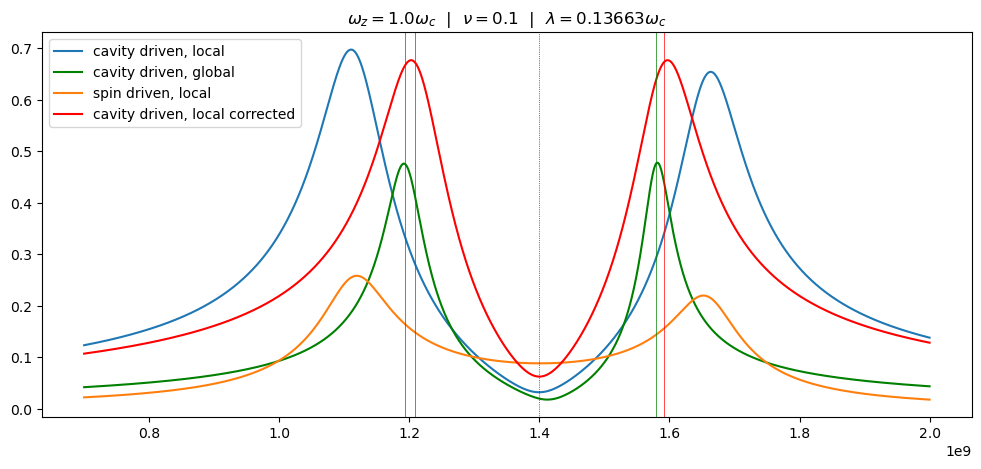

In [33]:
plt.rcParams["figure.figsize"] = (12, 5)

wc = 1.4e9  # freq cavidad FIJA
kappa = 0.05 * wc  # damping cavidad FIJO
gamma1 = 0.05 * wc  # damping cavidad FIJO
kb = 1.38064852e-23  # constante
hbar = 1.0545718e-34  # constante
h = 6.62607015e-34  # constante
c = 5.124350564859e-19  # constante
rho = 5.1e26  # densidad espines FIJA
nu = 0.1  # nu VARIABLE
lam = np.sqrt(c * rho * nu * wc)  # analogo a Brms, depende de nu, rho y wc FIJO
print("lam/wc:", lam / wc)

T = 0.0001  # Temperatura FIJA a cero

wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo
print("wzc/wc:", wzc / wc)

wz = 1 * wc  # freq espines VARIABLE
print("wz/wc", wz / wc)
# print('wz/wzc', wz / wzc)
gamma = 0.025 * wz  # damping espines FIJO
gamma2 = 0.025 * wz  # damping espines FIJO

ws = np.linspace(0.7, 2, 5000) * 1e9  # freq de barrido

plt.plot(ws, f_trans(wz, wc, ws, lam, T), label="cavity driven, local")
plt.plot(
    ws,
    [full_calc(w, wc, wz, lam, gamma1, gamma2) for w in ws],
    label="cavity driven, global",
    c="g",
)
plt.plot(ws, f_trans_alt(wz, wc, ws, lam, T), label="spin driven, local")
plt.plot(
    ws, f_trans_proper(wz, wc, ws, lam), label="cavity driven, local corrected", c="r"
)
plt.title(
    rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="r", lw=0.5)
# -----------------------------------------

plt.axvline(wc, c="k", lw=0.5, ls="dotted")

plt.legend()
plt.show()

lam/wc: 0.3017804310611087


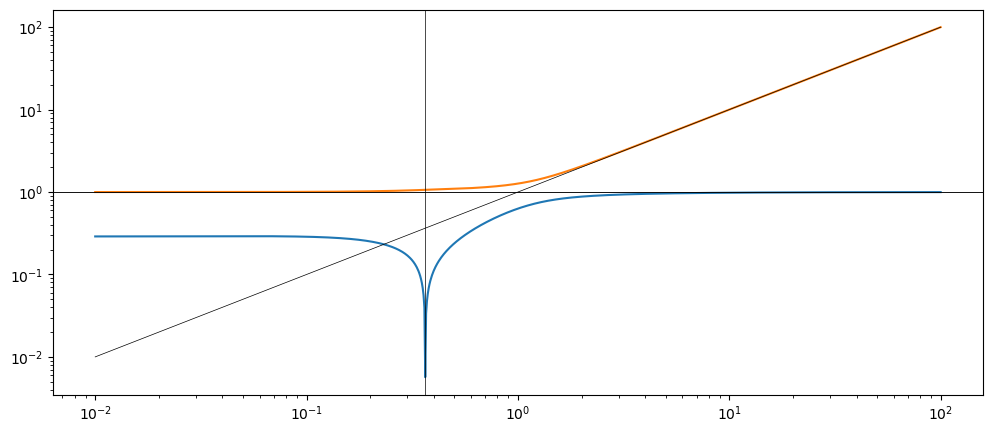

In [34]:
wc = 1.4e9  # freq cavidad FIJA
kappa = 0.01 * wc  # damping cavidad FIJO
kb = 1.38064852e-23  # constante
hbar = 1.0545718e-34  # constante
h = 6.62607015e-34  # constante
c = 5e-19  # constante
rho = 5.1e26  # densidad espines FIJA
nu = 0.5  # nu VARIABLE
lam = np.sqrt(c * rho * nu * wc)  # analogo a Brms, depende de nu, rho y wc FIJO
print("lam/wc:", lam / wc)

T = 0.0001  # Temperatura FIJA a cero

wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo

wzs = np.logspace(-2, 2, 1000) * wc
# wzs = np.linspace(0, 2, 1000) * wc

pps = []
pms = []
for wz in wzs:
    pm, pp = polaritons(wz, wc, lam)
    pps.append(pp)
    pms.append(pm)
pps = np.array(pps)
pms = np.array(pms)

plt.plot(wzs / wc, pms / wc)
plt.plot(wzs / wc, pps / wc)
plt.xscale("log")
plt.yscale("log")
plt.axhline(1, lw=0.5, c="k")
plt.plot(wzs / wc, wzs / wc, lw=0.5, c="k")
plt.axvline(wzc / wc, lw=0.5, c="k")
plt.axhline(np.sqrt(1 + 2 * (lam / wc) ** 4), lw=0.5, c="k")
plt.show()

0.3017804310611087
0.3642857142857142


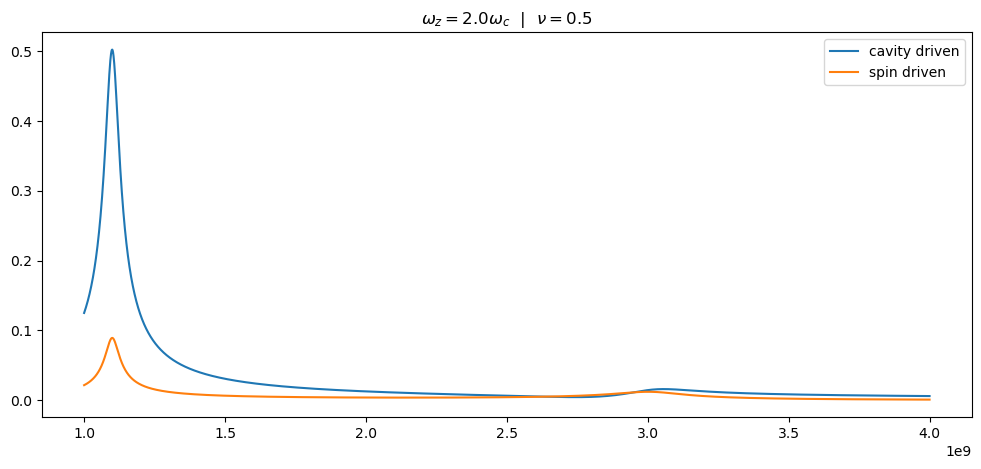

In [35]:
wc = 1.4e9
kappa = 0.01 * wc
kb = 1.38064852e-23
hbar = 1.0545718e-34
h = 6.62607015e-34
c = 5e-19
rho = 5.1e26
nu = 0.5
lam = np.sqrt(c * rho * nu * wc)
print(lam / wc)

T = 0.0001

wzc = 4 * lam**2 / wc
print(wzc / wc)

wz = 2 * wc
gamma = 0.05 * wz

ws = np.linspace(1, 4, 5000) * 1e9

plt.plot(ws, f_trans(wz, wc, ws, lam, T), label="cavity driven")
plt.plot(ws, f_trans_alt(wz, wc, ws, lam, T), label="spin driven")
plt.title(rf"$\omega_z = {wz / wc} \omega_c$" + "  |  " + rf"$\nu = {nu}$")
plt.legend()
plt.show()

In [36]:
wc = 1.4e9
kappa = 0.025 * wc
kb = 1.38064852e-23
hbar = 1.0545718e-34
h = 6.62607015e-34
c = 5e-19
rho = 5.1e26
nu = 0.5
lam = np.sqrt(c * rho * nu * wc)
print(lam / wc)

T = 0.0001

wzc = 4 * lam**2 / wc
print(wzc / wc)

wz = 0.5 * wc
gamma = 0.025 * wz

ws = np.linspace(0, 2, 5000) * 1e9

plt.plot(ws, f_trans(wz, wc, ws, lam, T), label=rf"$\nu = {nu}$")
plt.title(rf"$\omega_z = {wz / wc} \omega_c$")
plt.legend()
plt.show()

0.3017804310611087
0.3642857142857142


KeyboardInterrupt: 

0.3534826728426727
0.4998
0.6862745098039216


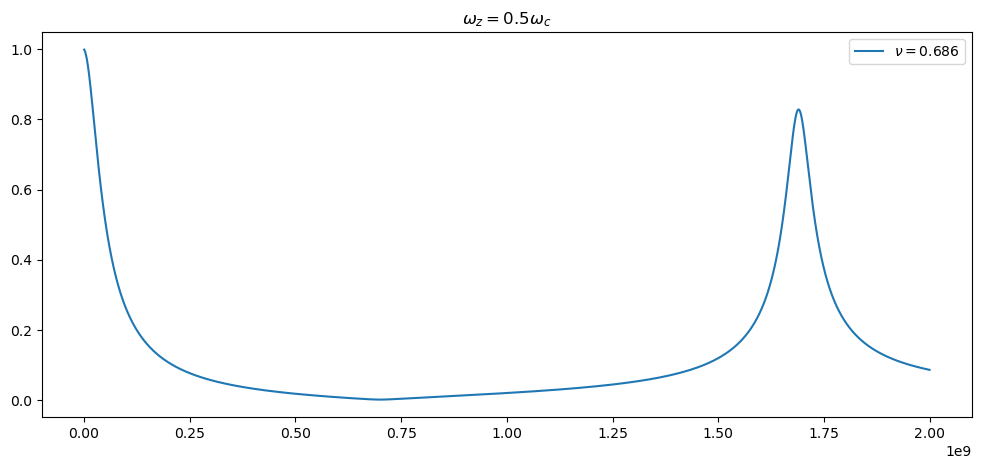

In [ ]:
wc = 1.4e9
kappa = 0.025 * wc
kb = 1.38064852e-23
hbar = 1.0545718e-34
h = 6.62607015e-34
c = 5e-19
rho = 5.1e26
nu = 0.686
lam = np.sqrt(c * rho * nu * wc)
print(lam / wc)

T = 0.0001

wzc = 4 * lam**2 / wc
print(wzc / wc)

wz = 0.5 * wc
gamma = 0.025 * wz
lamc = 0.5 * np.sqrt(wz * wc)
nuc = lamc**2 / (c * rho * wc)
print(nuc)

ws = np.linspace(0, 2, 5000) * 1e9

plt.plot(ws, f_trans(wz, wc, ws, lam, T), label=rf"$\nu = {nu}$")
plt.title(rf"$\omega_z = {wz / wc} \omega_c$")
plt.legend()
plt.show()

In [ ]:
a = np.zeros(3)
print(np.append(a, 2))

[0. 0. 0. 2.]


# Benchmark 1: Original LLG (only spin), should be equivalent to default Mumax3

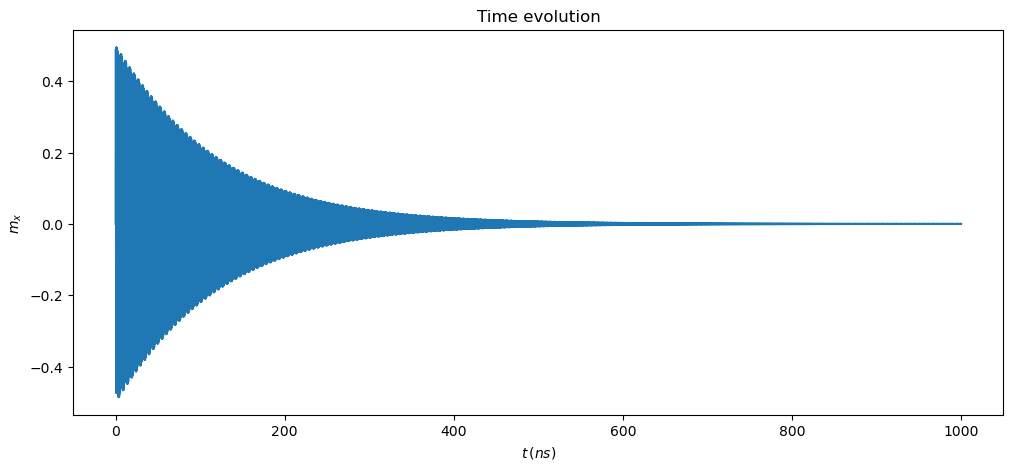

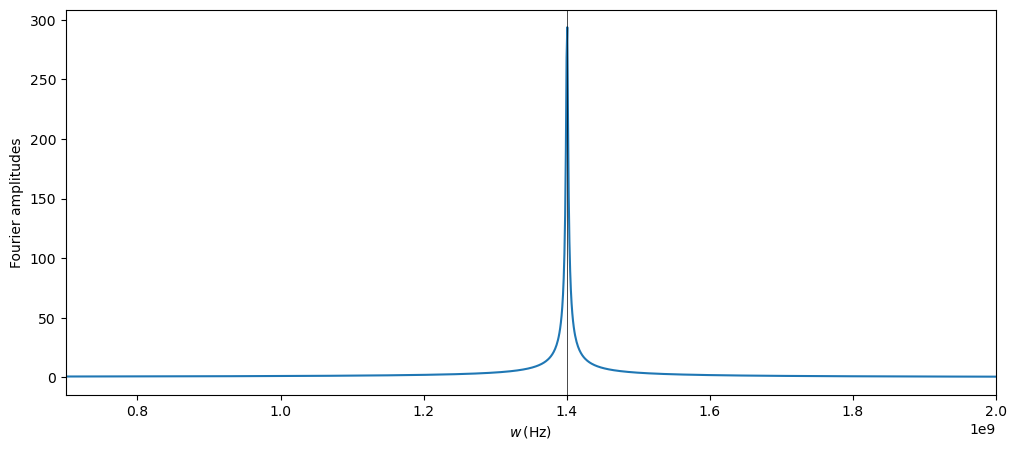

In [175]:
N = 100
tmax = 1000e-9
alpha = 1e-3
my0 = 0.5
m0 = np.array([0, my0, -np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2 * np.pi
wz = 1.4e9
Beff = np.array([0, 0, 2 * np.pi * wz / gammaLL])
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG, (0, tmax), m0, args=(Beff, gammaLL, alpha), t_eval=t_eval)
ws = fftfreq(len(sol.t), sol.t[1] - sol.t[0])
amps = np.abs(fft(sol.y[0]))
plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()
plt.plot(ws[: len(ws) // 2], amps[: len(ws) // 2])
plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

# Benchmark 2: Evolution of a cavity

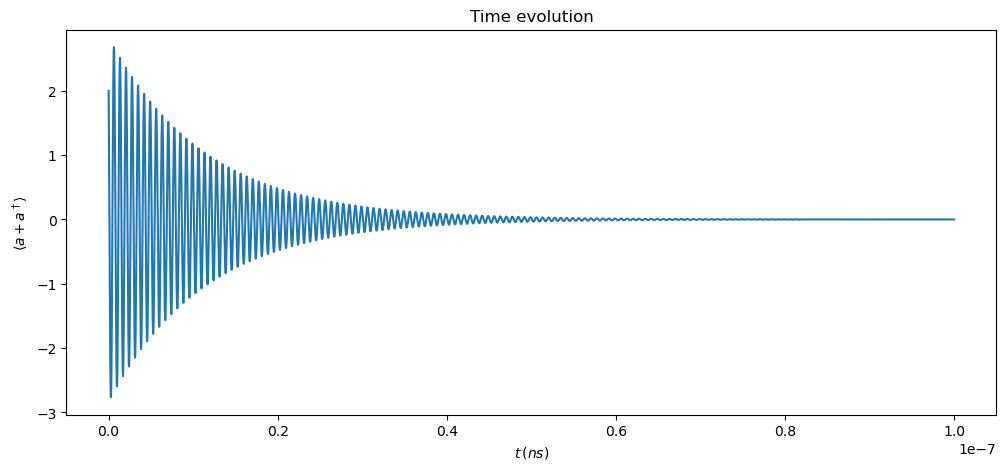

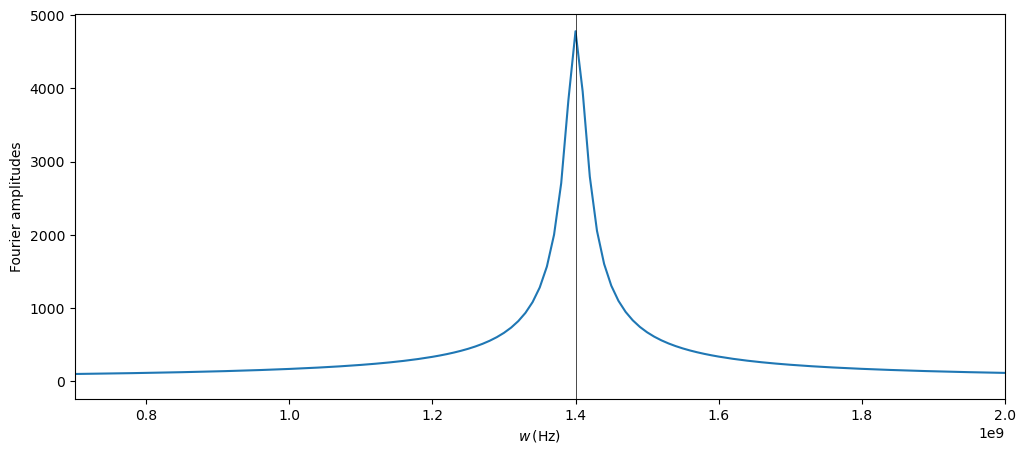

In [176]:
tmax = 100e-9

m0 = np.array([2, 2])
wc = 1.4e9 * 2 * np.pi
kappa = 0.01 * wc

t_eval = np.linspace(0, tmax, 30000)
sol = solve_ivp(
    cavity_real, (0, tmax), m0, args=(wc, kappa), t_eval=t_eval
)  # , max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t), sol.t[1] - sol.t[0])
amps = np.abs(fft(sol.y[0]))
plt.plot(sol.t, sol.y[0])
plt.ylabel(r"$\langle a + a^\dagger \rangle$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()
plt.plot(ws[: len(ws) // 2], amps[: len(ws) // 2])
plt.xlim(0.7e9, 2e9)
plt.axvline(1.4e9, c="k", lw=0.5)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.show()

# Explicit solution of spin + cavity system (explicit equations of motion for both spin and cavity DOFs)

[0.   0.   0.05]
[0.00216028 0.         0.        ]


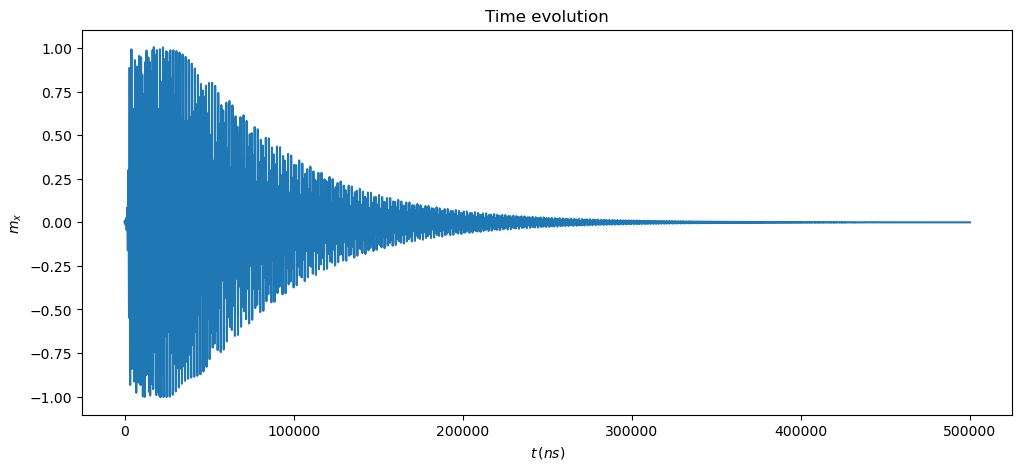

gap/lam: 1.025480152774383


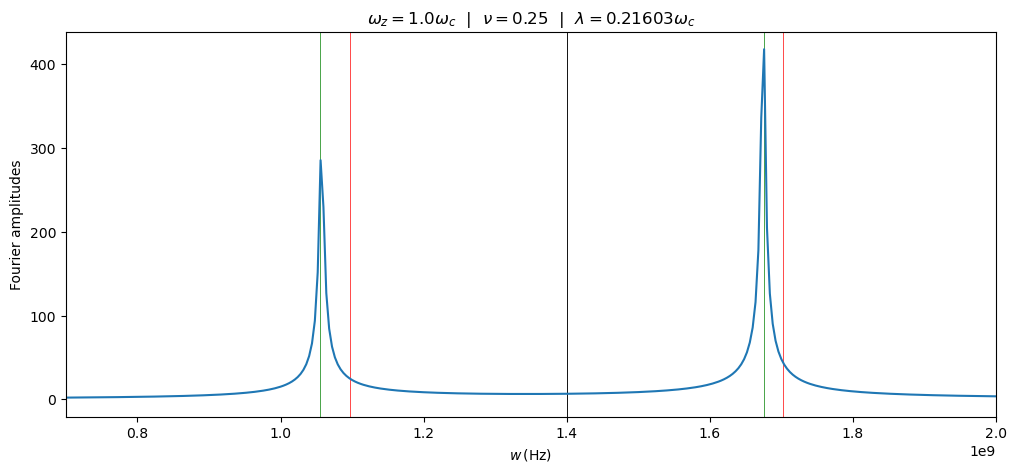

In [177]:
N = 100
tmax = 500e-9  # 1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, -np.sqrt(1 - my0**2), 0, 0])
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 0.005 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 0.25
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
print(Bext)
print(Brms)

t_eval = np.linspace(0, tmax, 500000)  # 100000
dt = 0.01e-9
sol = solve_ivp(
    LLG_explicit_real,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
)  # , max_step=dt, atol = 1, rtol = 1
ws = fftfreq(
    len(sol.t) // 2, sol.t[1] - sol.t[0]
)  # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2 :]))  # discard first half of time evolution
plt.plot(sol.y[0])
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()
plt.axvline(wc, c="k", lw=0.5)
plt.axvline(wz, c="k", lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="r", lw=0.5)
# -----------------------------------------
plt.plot(ws[: len(ws) // 2], amps[: len(ws) // 2])
# plt.xlim(0.1e9, 2e9)
# plt.ylim(0, 1e-10)
plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.title(
    rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
)

plt.show()

# Implicit solution of spin + cavity system (cavity DOFs integrated out), should be equivalent to modified Mumax3

[0.   0.   0.05]
[0.00216028 0.         0.        ]


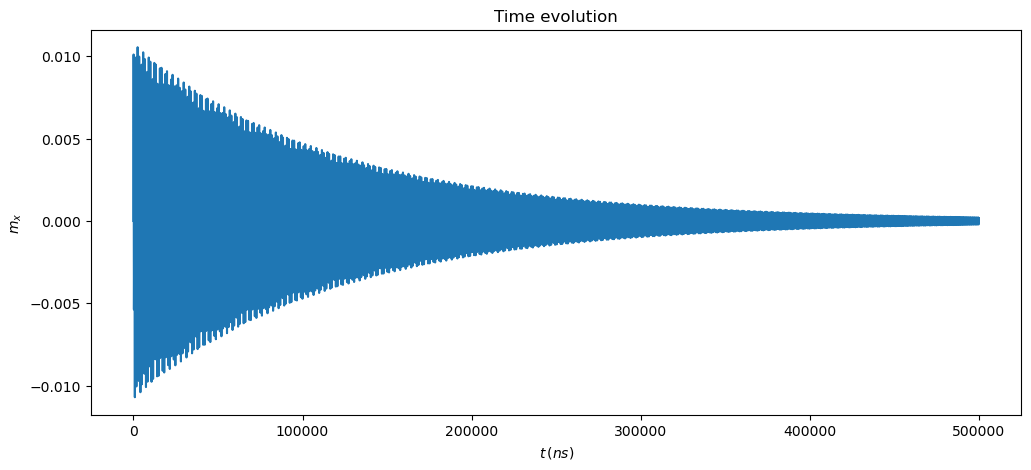

gap/lam: 1.025480152774383


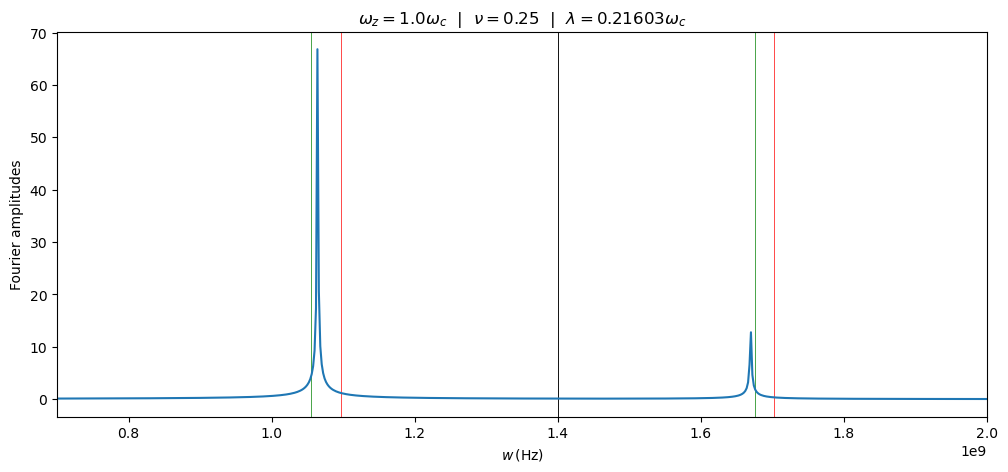

In [178]:
N = 100
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, -np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 0.25
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
print(Bext)
print(Brms)

t_eval = np.linspace(0, tmax, 500000)  # 100000
dt = 0.01e-9
sol = solve_ivp(
    LLG_memory,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, N, dt, gammaLL, alpha),
    t_eval=t_eval,
    max_step=dt,
    atol=1,
    rtol=1,
)
ws = fftfreq(
    len(sol.t) // 2, sol.t[1] - sol.t[0]
)  # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2 :]))  # discard first half of time evolution
plt.plot(sol.y[0])
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()
plt.axvline(wc, c="k", lw=0.5)
plt.axvline(wz, c="k", lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="r", lw=0.5)
# -----------------------------------------
plt.plot(ws[: len(ws) // 2], amps[: len(ws) // 2])
# plt.xlim(0.1e9, 2e9)
# plt.ylim(0, 1e-10)
plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.title(
    rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
)

plt.show()

In [ ]:
M = np.array([[1, 2], [3, 4]])

a = np.array([1, 2])

print(np.dot(M, a))

[ 5 11]
